In [1]:
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path

import matplotlib.pyplot as plt
import arviz as az
import os
import tqdm

import sys
sys.path.append('../scripts')

from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [3]:
stanfile = os.path.join('..', 'scripts', 'bivariate-beta-model.stan')
model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS':'true'})

INFO:cmdstanpy:found newer exe file, not recompiling


Generating the data

In [4]:
alpha = np.array([1,1,1,1])
n = 50
U = np.random.dirichlet(alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

a = np.array([1,1,1,1])
b = np.array([1,1,1,1])

data = {'n': n, 'xy': XY, 'a': a, 'b': b, 'tolerance': 1e-8}

In [5]:
model_fit = model.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [6]:
print(model_fit.diagnose())

Processing csv files: /tmp/tmpfuwkwaj6/bivariate-beta-model-20220614222953_1.csv, /tmp/tmpfuwkwaj6/bivariate-beta-model-20220614222953_2.csv, /tmp/tmpfuwkwaj6/bivariate-beta-model-20220614222953_3.csv, /tmp/tmpfuwkwaj6/bivariate-beta-model-20220614222953_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,13.00,0.0340,1.40,10.00,13.00,15.0,1700.0,3.2,1.0
alpha[1],1.00,0.0045,0.21,0.70,1.00,1.4,2244.0,4.2,1.0
alpha[2],1.10,0.0051,0.23,0.74,1.10,1.5,2107.0,3.9,1.0
alpha[3],0.83,0.0046,0.21,0.50,0.82,1.2,2019.0,3.8,1.0
alpha[4],1.40,0.0055,0.26,0.96,1.40,1.8,2335.0,4.3,1.0


In [8]:
inf_data = az.from_cmdstanpy(model_fit)

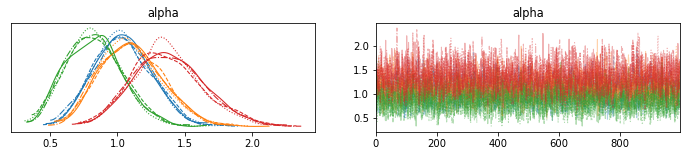

In [13]:
az.plot_trace(inf_data)
plt.show()

In [17]:
stanfile = os.path.join('..', 'scripts', 'bivariate-beta-model-v2.stan')
model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS':'true'})

INFO:cmdstanpy:compiling stan file /home/lucasmoschen/Documents/GitHub/bivariate-beta/scripts/bivariate-beta-model-v2.stan to exe file /home/lucasmoschen/Documents/GitHub/bivariate-beta/scripts/bivariate-beta-model-v2
INFO:cmdstanpy:compiled model executable: /home/lucasmoschen/Documents/GitHub/bivariate-beta/scripts/bivariate-beta-model-v2


In [18]:
model_fit_v2 = model.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [29]:
df = model_fit_v2.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.00,0.0055,0.21,0.70,1.00,1.4,1512.0,239.0,1.0
alpha[2],1.10,0.0073,0.24,0.76,1.10,1.5,1076.0,170.0,1.0
alpha[3],0.85,0.0075,0.21,0.52,0.83,1.2,802.0,127.0,1.0
alpha[4],1.40,0.0062,0.26,0.97,1.40,1.8,1726.0,273.0,1.0


In [31]:
model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,13.00,0.0340,1.40,10.00,13.00,15.0,1700.0,3.2,1.0
alpha[1],1.00,0.0045,0.21,0.70,1.00,1.4,2244.0,4.2,1.0
alpha[2],1.10,0.0051,0.23,0.74,1.10,1.5,2107.0,3.9,1.0
alpha[3],0.83,0.0046,0.21,0.50,0.82,1.2,2019.0,3.8,1.0
alpha[4],1.40,0.0055,0.26,0.96,1.40,1.8,2335.0,4.3,1.0


## Analyzing the estimation

In [64]:
alpha = np.array([1,1,1,1])
n = 50
monte_carlo_simulation = 100
U = np.random.dirichlet(alpha, size=(n, monte_carlo_simulation))
X = U[:,:,0] + U[:,:,1]
Y = U[:,:,0] + U[:,:,2]

a = np.array([1,1,1,1])
b = np.array([1,1,1,1])

In [65]:
mse = np.zeros(4)
bias = np.zeros(4)
coverage = np.zeros(4)
mape = np.zeros(4)

for i in tqdm.tqdm(range(monte_carlo_simulation)):
    XY = np.column_stack([X[:,i],Y[:,i]])
    data = {'n': n, 'xy': XY, 'a': a, 'b': b, 'tolerance': 1e-8}
    model_fit_v2 = model.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    df = model_fit_v2.summary(percentiles=(2.5, 97.5))
    
    alpha_hat = df.iloc[1:5].Mean.values
    lb = df.iloc[1:5]['2.5%'].values
    ub = df.iloc[1:5]['97.5%'].values
    
    bias_new = alpha_hat - alpha
    mse_new = bias_new * bias_new
    mape_new = abs(bias_new)/alpha
    coverage_new = (lb < alpha)*(ub > alpha)
    
    bias = (bias * i + bias_new)/(i+1)
    mse = (mse * i + mse_new)/(i+1)
    mape = (mape * i + mape_new)/(i+1)
    coverage = (coverage * i + coverage_new)/(i+1)

  0%|                                                   | 0/100 [00:00<?, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  1%|▍                                          | 1/100 [00:04<07:07,  4.32s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  2%|▊                                          | 2/100 [00:08<06:57,  4.26s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  3%|█▎                                         | 3/100 [00:12<06:36,  4.09s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  4%|█▋                                         | 4/100 [00:16<06:25,  4.01s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  5%|